In [1]:
import numpy as np
from stats import LinearSolveStats, TimeStepStats
from stats import TimeStepStats
from matplotlib import pyplot as plt
from plot_utils import *

# data = load_data("../stats/fpm_2_closed_sticking_solver_1_numba.json")
# data = load_data("../stats/fpm_2_closed_sliding_solver_1_numba.json")
# data = load_data("../stats/fpm_2_closed_open_solver_1_numba.json")
# data = load_data("../stats/fpm_2_closed_m_sliding_solver_1_numba.json")

data = load_data("../stats/fpm_0_sticking_solver_1_numba.json")
# data = load_data("../stats/fpm_0_sliding_solver_1_numba.json")
# data = load_data("../stats/fpm_0_open_solver_1_numba.json")

# data = load_data("../stats/fpm_1_sticking_solver_1_numba.json")
# data = load_data("../stats/fpm_1_sliding_solver_1_numba.json")
# data = load_data("../stats/fpm_1_open_solver_1_numba.json")

# data = load_data("../stats/fpm_01_open_solver_1_numba.json")
# data = load_data("../stats/fpm_01_sticking_solver_1_numba.json")


# data = load_data("../stats/fpm_1_sticking_direct_numba.json")

In [2]:
import porepy as pp
import numpy as np
from mat_utils import *
from plot_utils import *
# from fpm_2_closed_m import make_model
# from fpm_2_closed import make_model
from fpm_0 import make_model
# from fpm_01 import make_model
# from fpm_1 import make_model
# from fpm_1_m import make_model


from pp_utils import make_row_col_dofs, make_reorder_contact

model = make_model()
model.prepare_simulation()

model.before_nonlinear_loop()
model.before_nonlinear_iteration()

model._initialize_solver()
eq_dofs, var_dofs = make_row_col_dofs(model)

reorder = make_reorder_contact(model)


# model.assemble_linear_system()
# mat, rhs = model.linear_system

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


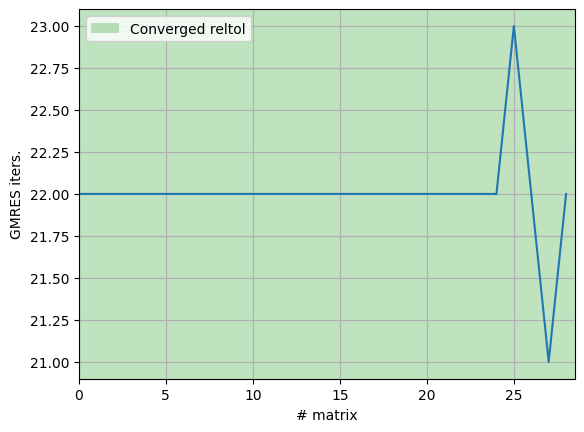

In [3]:
# %matplotlib ipympl
color_converged_reason(data)
plt.plot(get_gmres_iterations(data))
plt.ylabel('GMRES iters.')
plt.xlabel('# matrix')
# plt.yscale('log')
plt.legend()

In [4]:
mat_idx = 10
get_gmres_iterations(data)[mat_idx]

22

In [5]:
sticking, sliding, open_ = get_num_sticking_sliding_open(data)
transition = get_num_transition_cells(data)
sticking = sticking[mat_idx]
sliding = sliding[mat_idx]
open_ = open_[mat_idx]
transition = int(transition[mat_idx])
total = sticking + sliding + open_
print(f'{sticking = }', f'{sliding = }', f'open = {open_}', f'{transition = }', f'{total = }', sep='\n')

sticking = 14
sliding = 0
open = 0
transition = 14
total = 14


In [8]:
from plot_utils import *

mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(data, mat_idx)

# model.time_manager.dt = dt
# model.before_nonlinear_loop()
# model.before_nonlinear_iteration()
# model.equation_system.set_variable_values(state, time_step_index=0)
# model.equation_system.set_variable_values(iterate, iterate_index=0)
# model.rediscretize()
# model.assemble_linear_system()

# assert (model.linear_system[0] - mat).data.size == 0
# assert np.all(model.linear_system[1] == rhs)

# mat, rhs = model.linear_system

# mat = mat[reorder]
# rhs = rhs[reorder]

* GMRES right unprec_norm - 0.000125
* GMRES left prec_norm - 0.000118 (tol=1e-15)

Solve  took: 0.07
True residual decrease: 0.00011375650750817528


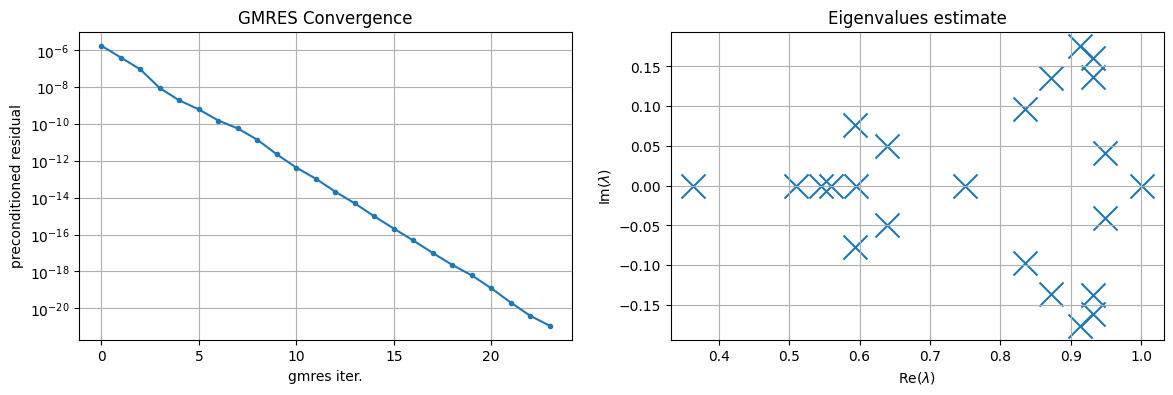

In [9]:
model.linear_system = mat, rhs
model.equation_system.set_variable_values(state, iterate_index=0)
perm_mat, prec_orig = model._prepare_solver()
solve_petsc(perm_mat.mat, prec_orig, rhs=perm_mat.local_rhs(rhs), tol=1e-15)

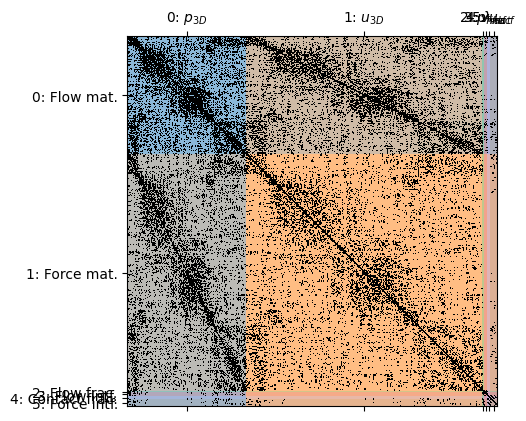

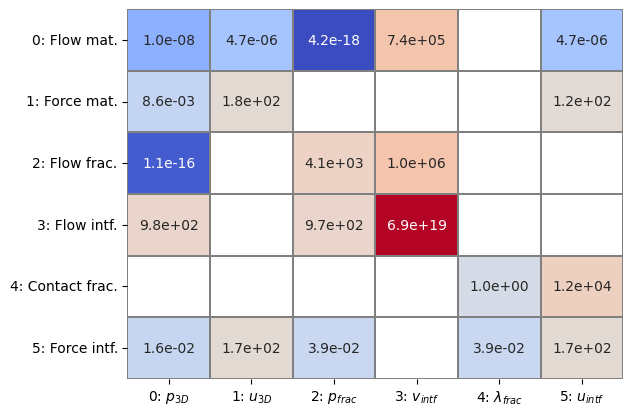

In [10]:
from block_matrix import BlockMatrixStorage
from pp_utils import correct_eq_groups

J = model.bmat
J.groups_row_names = [
    r"Flow mat.",
    r"Force mat.",
    r"Flow frac.",
    r"Flow intf.",
    r"Contact frac.",
    "Force intf.",
]
J.groups_col_names = [
    r"$p_{3D}$",
    r"$u_{3D}$",
    r"$p_{frac}$",
    r"$v_{intf}$",
    r"$\lambda_{frac}$",
    "$u_{intf}$",
]

J[:].color_spy()
J[:].plot_max()

## How accurately can direct solver solve it?

In [14]:
# Jinv = inv(J.mat)

In [16]:
# x = Jinv @ rhs
# norm(J.mat @ x - rhs) / norm(rhs)

* GMRES right unprec_norm - 0.00028 (tol=1e-9)
* GMRES left prec_norm - 0.0003 (tol=1e-9)

Solve  took: 0.08
True residual decrease: 0.0003034820260538276


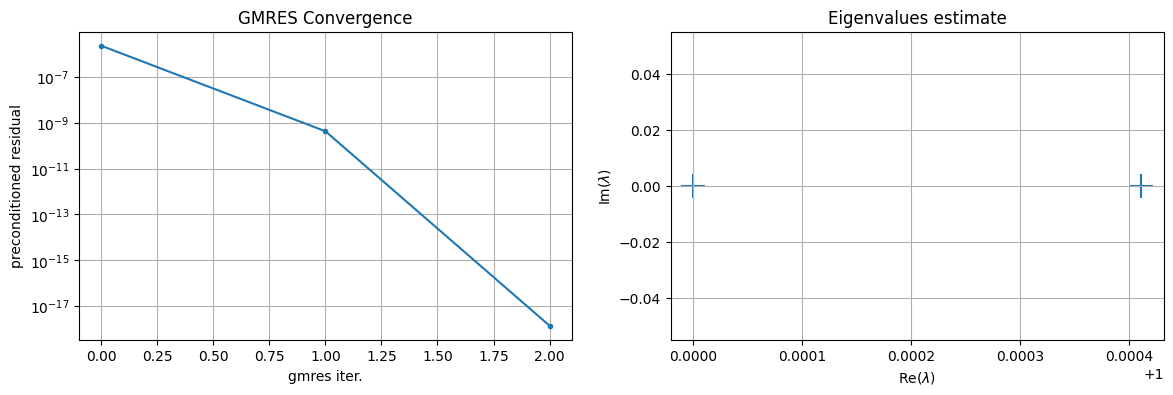

In [11]:
# solve_petsc(J.mat, Jinv, J.local_rhs(rhs), tol=1e-9)

# How is stabilized matrix different from the original one?

## Mechanics only [4, 5]

/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


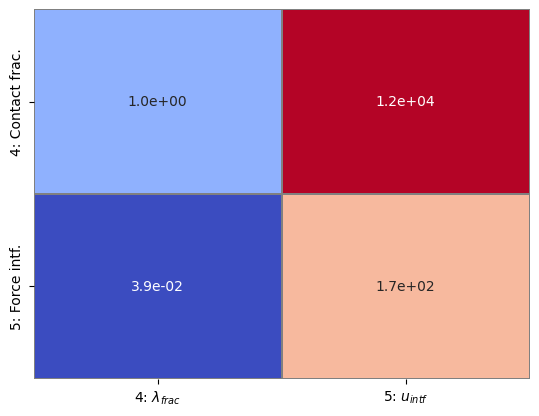

In [19]:
Jmech = J[[4,5]]

Jmech_stab = Jmech.copy()
J55_inv = inv_block_diag(Jmech_stab[[5]].mat, nd=model.nd)
Jmech_stab[[4]] = Jmech_stab[[4]].mat - Jmech_stab[4, 5].mat @ J55_inv @ Jmech_stab[5, 4].mat
Jmech.plot_max()

Jmech_stab_inv = inv(Jmech_stab.mat)

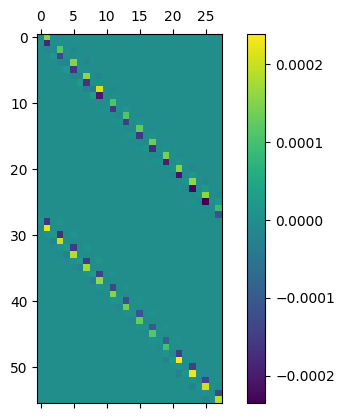

2.1736147989069714


In [43]:
left = Jmech.empty_container()
left.mat = Jmech_stab_inv @ Jmech.mat
# left.plot_max()
left[5,4].matshow(log=False)
print(cond(left.mat))

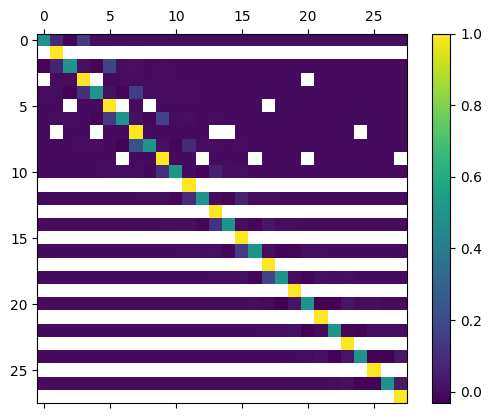

29752.8175695554


In [40]:
right = Jmech.empty_container()
right.mat = Jmech.mat @ Jmech_stab_inv
# right.plot_max()
right[4, 4].matshow(log=False)
print(cond(right.mat))

Solve  took: 0.0
True residual decrease: 3.4771791963421826e-10


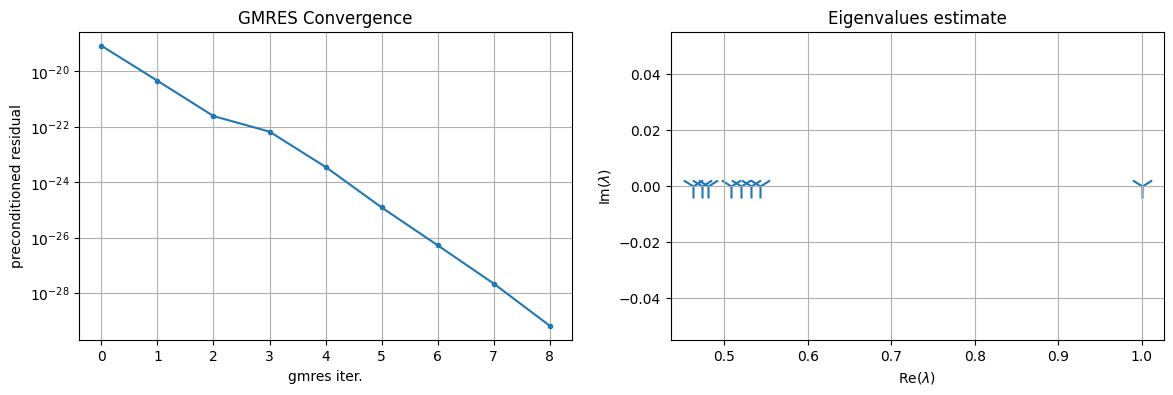

In [27]:
solve_petsc(Jmech.mat, Jmech_stab_inv, rhs=Jmech.local_rhs(rhs), pc_side='left')

Solve  took: 0.0
True residual decrease: 1.3718212770712255e-11


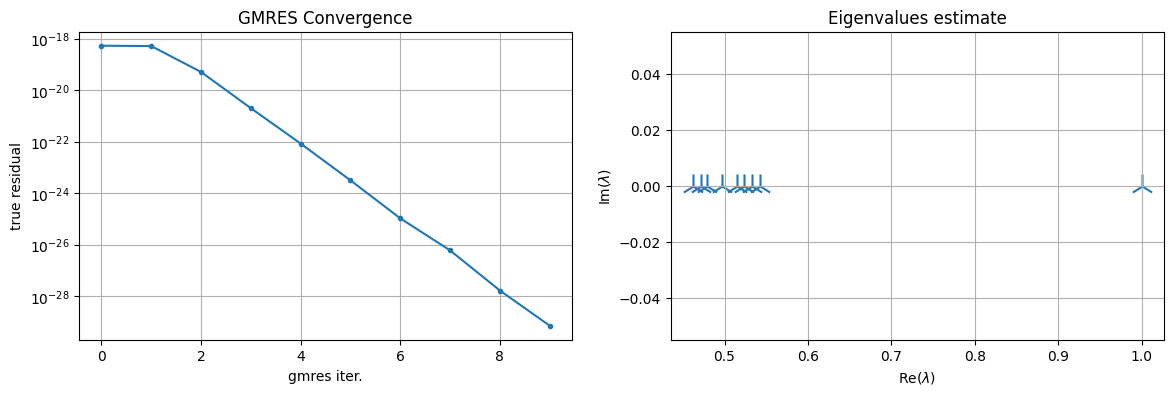

In [28]:
solve_petsc(Jmech.mat, Jmech_stab_inv, rhs=Jmech.local_rhs(rhs), pc_side='right')

## What changes with the flow?

/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


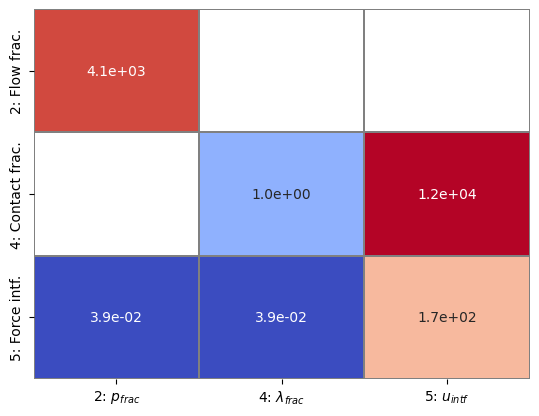

In [44]:
Jfm = J[[2,4,5]]

Jfm_stab = Jfm.copy()
Jfm_stab[[4]] = Jfm_stab[[4]].mat - Jfm_stab[4, 5].mat @ J55_inv @ Jfm_stab[5, 4].mat

Jfm.plot_max()
Jfm_stab_inv = inv(Jfm_stab.mat)

2.173659319520971


Text(0.5, 1.0, 'Left')

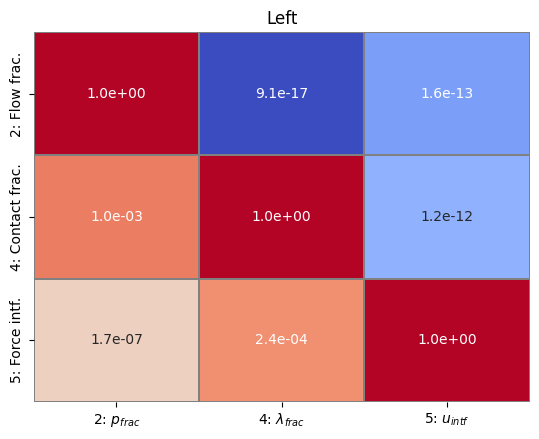

In [47]:
left = Jfm_stab.empty_container()
left.mat = Jfm_stab_inv @ Jfm.mat
left.plot_max()
print(cond(left.mat))
plt.title('Left')

2.337281554845302e+20


Text(0.5, 1.0, 'Right')

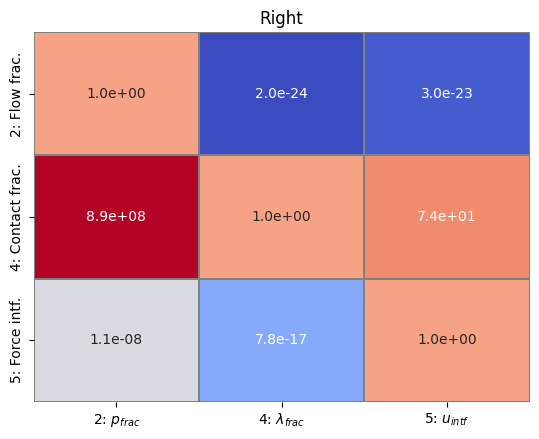

In [48]:
right = Jfm_stab.empty_container()
right.mat = Jfm.mat @ Jfm_stab_inv
right.plot_max()
print(cond(right.mat))
plt.title('Right')

* $\tilde{A}^{-1} \cdot A$ - ok (left prec)
* $A \cdot \tilde{A}^{-1}$ - bad (right prec)

Q: Is GMRES left or right? 

A: Was right and didn't work, now left and works?

Solve  took: 0.0
True residual decrease: 0.0009537661502409728


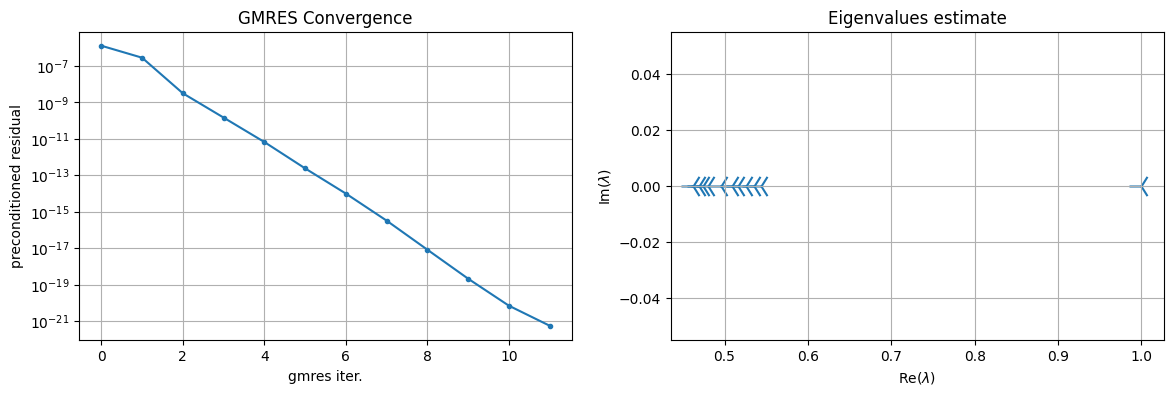

In [34]:
solve_petsc(Jfm.mat, Jfm_stab_inv, rhs=Jfm.local_rhs(rhs), tol=1e-15, pc_side='left')

Solve  took: 0.0
True residual decrease: 1.2174452196050436
PETSc Converged Reason: -5
lambda min: 10.238924773124568


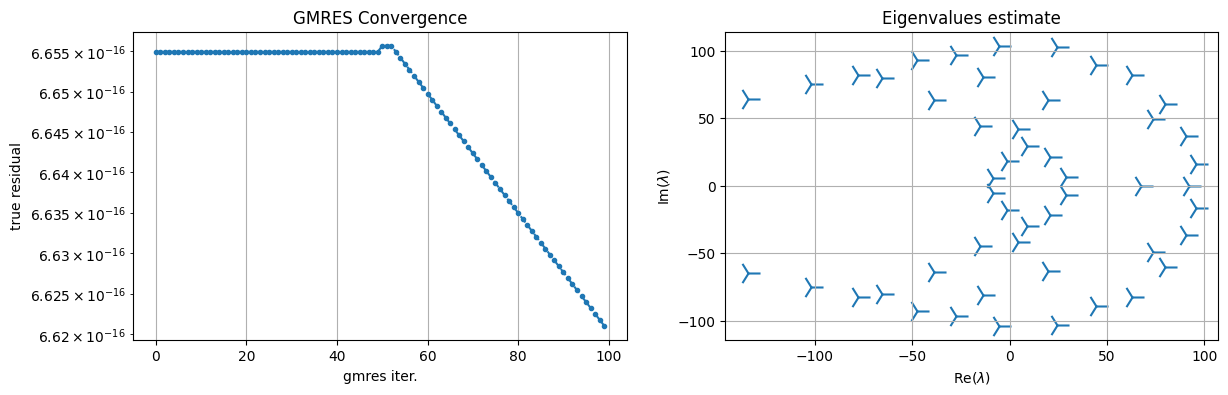

In [35]:
solve_petsc(Jfm.mat, Jfm_stab_inv, rhs=Jfm.local_rhs(rhs), tol=1e-15, pc_side='right')